<a href="https://colab.research.google.com/github/dknugo/crypto-research/blob/main/FTX_perp_arbitrage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Perpetual/spot arbitrage on FTX

This notebook provides analysis of perp / spot arbirtage trading on FTX exchange. Analysis covers the following questions:
* What are potential sources of returns and how to exploit them?
* How to choose trading pairs?
* How to size positions properly?
* Does borrowing increase returns?
* How to mitigate liquidation risks?
* How and when to enter and exit the trade?

Some data is fetched online via FTX API (you need to provide your own key), some analysis requires direct access to Timescale DB preloaded with data from FTX.

Access to FTX API is implemented by [CCXT](https://opencollective.com/ccxt) library.

## Initialize

In [7]:
!pip install ccxt
!pip install psycopg2

import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import ccxt
import psycopg2
import seaborn as sns
from collections.abc import Iterable

# Globals
# Data can be loaded from CSV files or TimescaleDB
# data_source = 'db'
data_source = 'csv'
db_conn_str = 'ENTER YOU CONNECTION STRING HERE' # onlyy required for 'db' data source

if data_source == 'db':
  db_conn = psycopg2.connect(db_conn_str)

print('CCXT Version:', ccxt.__version__)
# FTX API connection
ftx = ccxt.ftx({
    'enableRateLimit': True,
    'apiKey': 'YOUR PUBLIC KEY',
    'secret': 'YOUR PRIVATE KEY',
})
ftx.load_markets ()
# FTX was founded in 2018
min_ts = ftx.parse8601('2018-01-01T00:00:00Z')

# Plot settings
plt.rcParams["figure.figsize"] = (16, 8)
def_title_size = 16
sns.set_theme(style = "ticks", palette = "pastel")

CCXT Version: 1.61.24


### Load data

In [8]:
# Load data
assert data_source in ['db', 'csv'], 'Unsupported data source'

if data_source == 'db':
  # Loading from TimescaleDB

  # Currencies
  sql = """SELECT ec.curr_code, c.name, ec.leveraged, ec.is_index
              FROM exch_currency AS ec
              INNER JOIN currency AS c ON ec.curr_code = c.code
              WHERE ec.exch_code = %(exch)s"""
  currs = pd.read_sql(sql, db_conn, params={'exch': 'ftx'}).set_index('curr_code').sort_index()

  # Collateral
  sql = """SELECT curr_code,
                    last(weight_total, ts_from) as weight_total,
                    last(weight_init, ts_from) as weight_init,
                    last(imf_factor, ts_from) as imf_factor
            FROM exch_collateral
            WHERE exch_code = %(exch)s
            GROUP BY curr_code"""
  collat = pd.read_sql(sql, db_conn, params={'exch': 'ftx'}).set_index('curr_code').sort_index()
  currs = currs.join(collat).fillna({'weight_total': 0, 'weight_init': 0})

  # Markets
  # Load all markets except:
  #  - tokenized equities
  #  - MOVE contracts
  #  - leveraged tokens
  sql = """SELECT em.symbol, em.active, em.base, em.quote, em.future, em.perpetual,
                  CASE WHEN perpetual IS TRUE THEN 'perpetual' WHEN future IS TRUE THEN 'future' ELSE 'spot' END as type,
                  ec.is_index
              FROM exch_market AS em
              LEFT JOIN exch_currency AS ec
                ON em.base = ec.curr_code
                  AND em.exch_code = ec.exch_code
              WHERE em.exch_code = %(exch)s
                AND em.tokenized_equity IS FALSE
                AND em.symbol not ilike '%%-MOVE-%%'
                AND ec.leveraged IS FALSE"""
  markets = pd.read_sql(sql, db_conn, params={'exch': 'ftx'}).set_index('symbol').sort_index()

  # Funding rates
  sql = """SELECT ts, symbol, rate, ann_rate
              FROM funding_rate
              WHERE exch_code = %(exch)s"""
  fund_rates = pd.read_sql(sql, db_conn, params={'exch': 'ftx'}).set_index(['ts', 'symbol']).sort_index()

  # Lending rates
  sql = """SELECT ts, curr_code, rate, ann_rate, size
              FROM lending_hist
              WHERE exch_code = %(exch)s"""
  lend_hist = pd.read_sql(sql, db_conn, params={'exch': 'ftx'}).set_index(['ts', 'curr_code']).sort_index()

  # Daily market candles
  sql = """SELECT ts, symbol, close, volume, closed
              FROM market_candle
              WHERE exch_code = %(exch)s
                AND timeframe = %(timeframe)s"""
  mprices_d = pd.read_sql(sql, db_conn, params={'exch': 'ftx', 'timeframe': '1d'}).set_index(['ts', 'symbol']).sort_index()

  # Daily index candles
  # sql = """SELECT ts, curr_code, close, closed
  #             FROM index_candle
  #             WHERE exch_code = %(exch)s
  #               AND timeframe = %(timeframe)s"""
  # iprices_d = pd.read_sql(sql, db_conn, params={'exch': 'ftx', 'timeframe': '1d'}).set_index(['ts', 'curr_code']).sort_index()

elif data_source == 'csv':
  # Load data from FTX and github
  
  currs = pd.read_csv('https://raw.githubusercontent.com/dknugo/crypto-research/main/data/ftx/ftx_currencies.csv', index_col=0)
  markets = pd.read_csv('https://raw.githubusercontent.com/dknugo/crypto-research/main/data/ftx/ftx_markets.csv', index_col=0)
  collat = pd.read_csv('https://raw.githubusercontent.com/dknugo/crypto-research/main/data/ftx/ftx_collateral.csv', index_col=0)
  fund_rates = pd.read_csv('https://raw.githubusercontent.com/dknugo/crypto-research/main/data/ftx/ftx_funding_rates.csv', index_col=0, parse_dates = True).set_index('symbol', append = True)
  lend_hist = pd.read_csv('https://raw.githubusercontent.com/dknugo/crypto-research/main/data/ftx/ftx_lending_hist.csv', index_col=0, parse_dates = True).set_index('curr_code', append = True)
  mprices_d = pd.read_csv('https://raw.githubusercontent.com/dknugo/crypto-research/main/data/ftx/ftx_market_prices_d.csv', index_col=0, parse_dates = True).set_index('symbol', append = True)


### FTX helpers

#### Price history

In [9]:
def get_ohlcv(symbol, timeframe = '1m', since = None, till = None, index = False):
  
  params = {'price':'index'} if index else {}
  
  bars_df = pd.DataFrame()
  start_ts = min_date if since is None else since 
  while True:
    bars = pd.DataFrame(ftx.fetchOHLCV(symbol, timeframe, since = start_ts, params = params), columns = ['time', 'open', 'high', 'low', 'close', 'volume'])
    if bars.empty: break
    bars['date'] = pd.to_datetime(bars['time'], unit = 'ms', utc = True)
    bars_df = bars_df.append(bars)
    start_ts = bars_df['time'].max() + 1000
    if till is not None and start_ts > till: break
     
  if len(bars_df):
    bars_df.drop_duplicates(inplace = True)
    bars_df = bars_df.set_index('date').sort_index()
    if till is not None:
      bars_df = bars_df[bars_df['time'] <= till] 
  
  return bars_df

# get_ohlcv('BTC-PERP', timeframe = '1h', since = ftx.parse8601('2021-11-01T00:00:00Z'), till = None, index = False)
# get_ohlcv('CRO/USD', timeframe = '1m', since = ftx.parse8601('2021-11-12T00:00:00Z'), till = None, index = False)

## What are potential sources of returns?

Trading perp arbitrage implies:
- Potential profits/losses on:
  * Funding payments
  * Trade exit (Sum of PnL of long and short positions when trade is closed)
- Certain costs:
  * Trading fees
  * Borrowing costs (if you borrow)
- Certain profits:
  * Lending proceeds (if you lend your assets)
  
Obviously you should minimize certain costs and increase the probability of profiting from perp funding and skillful trade execution. And earn some interest on spare funds.


## How much could you earn on funding?

In [10]:
def plot_frate(fr):
  last_ts = fr.index.get_level_values('ts').max()
  fr_24h = fr.loc(axis = 0)[last_ts - pd.DateOffset(days = 1):, ].groupby('symbol')['ann_rate'].mean()
  fr_week = fr.loc(axis = 0)[last_ts - pd.DateOffset(weeks = 1):, ].groupby('symbol')['ann_rate'].mean()
  fr_month = fr.loc(axis = 0)[last_ts - pd.DateOffset(months = 1):, ].groupby('symbol')['ann_rate'].mean()
  fr_3months = fr.loc(axis = 0)[last_ts - pd.DateOffset(months = 3):, ].groupby('symbol')['ann_rate'].mean()
  fr_year = fr.loc(axis = 0)[last_ts - pd.DateOffset(years = 1):, ].groupby('symbol')['ann_rate'].mean()
  fr_alltime = fr.groupby('symbol')['ann_rate'].mean()
  # fr_last_ts = fr.reset_index().groupby('symbol')['ts'].max()
  fr_df = pd.concat([fr_24h, fr_week, fr_month, fr_3months, fr_year, fr_alltime], axis = 1)
  fr_df.columns = ['last 24h', 'last week', 'last month', 'last 3 months', 'last year', 'all time']
  fr_df = fr_df.rename_axis('timeframe', axis = 1)

  fig, axs = plt.subplots(2, figsize=(16,8), sharex = True, gridspec_kw={'height_ratios': [1, 1]})
  # fig.subplots_adjust(top=0.9)
  fig.suptitle(f'Mean annualized funding rate across all perps on FTX\n(Last timestamp: {last_ts}', fontsize = def_title_size)
  # ax = sns.boxplot(x = "timeframe", y = 'mean_rate',
  #             orient = 'v',
  #             palette = ["m", "g"],
  #             showmeans = True,
  #             data = fr_df.reset_index())
  sns.set_style({'axes.grid' : True})
  splot = sns.barplot(ax = axs[0], x = "timeframe", y = "mean_rate", data = fr_df.mean().rename('mean_rate').reset_index())
  for p in splot.patches:
      splot.annotate(format(p.get_height(), '.1%'), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 9), 
                    textcoords = 'offset points')
  axs[0].yaxis.set_major_formatter(mtick.PercentFormatter(1, 0))
  axs[0].set_ylim(top = fr_df.mean().max() * 1.2)
  axs[0].set_xlabel('')
  sns.violinplot(ax = axs[1],
                  x = "timeframe", y = 'mean_rate',
                  orient = 'v',
                  palette = ["m", "g"],
                  showmeans = True,
                  data = fr_df.stack().rename('mean_rate').reset_index())
  # sns.despine(ax = axs[1], offset = 10, trim = True)
  axs[1].yaxis.set_major_formatter(mtick.PercentFormatter(1, 0))
  axs[1].set_xlabel('')
  axs[1].axhline(0, ls = '--', lw = 0.7, c = 'black')
  plt.show()

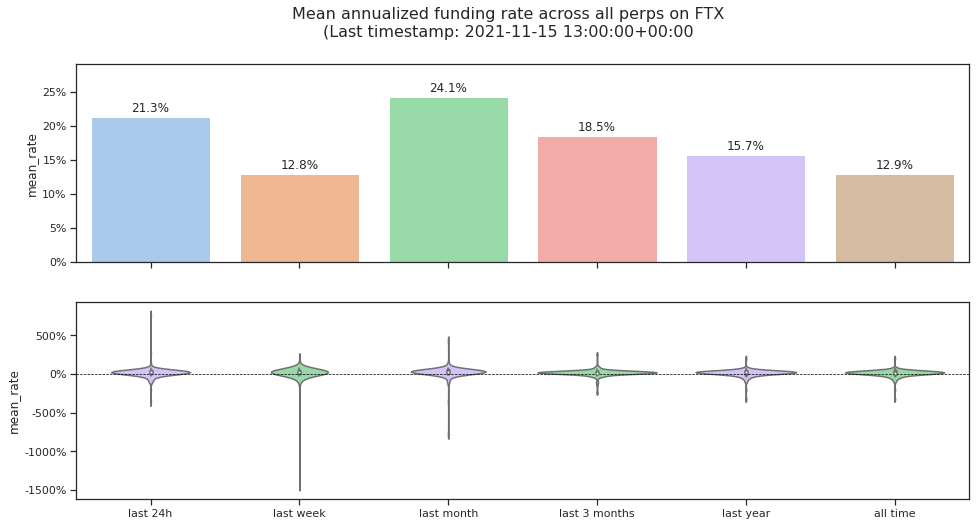

In [12]:
plot_frate(fund_rates)

* Perp funding payments are the major sources of profits.
* Rates are consistently positive on all timeframes.
* There're extreme outliers.

Let's dig deeper into the last month...

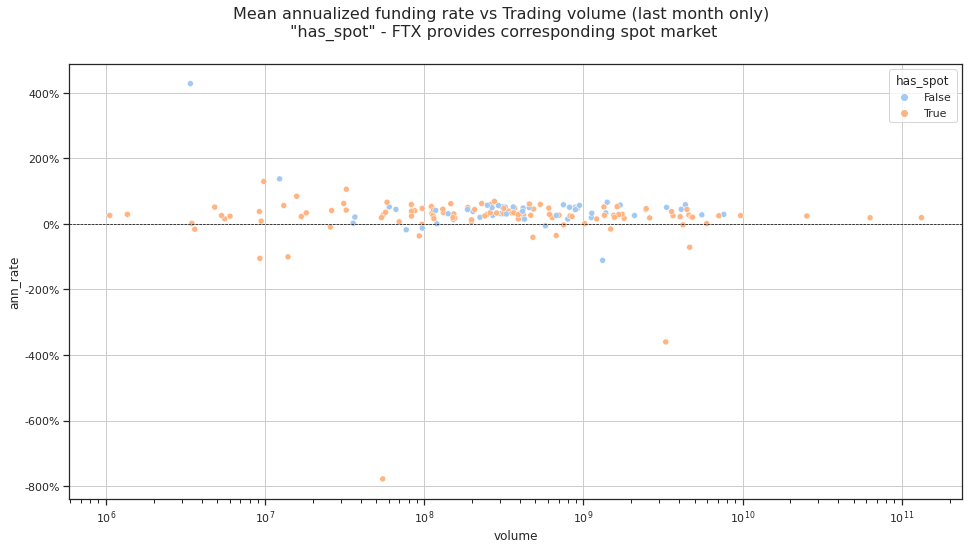

In [20]:
# Enrich data
# Add columns:
#  - volume: mean daily volume
#  - has_spot: True if perp has corresponding spot market
#  - weight_init: initial collateral weight
fr_month = fund_rates.loc(axis = 0)[(fund_rates.index.get_level_values('ts').max() - pd.DateOffset(months = 1)):, ].groupby('symbol')['ann_rate'].mean().to_frame()
fr_month['abs_ann_rate'] = fr_month['ann_rate'].abs()
volume_month = mprices_d.loc(axis = 0)[(mprices_d.index.get_level_values('ts').max() - pd.DateOffset(months = 1)):, ].groupby('symbol')['volume'].sum()
perp_spot_mapping = markets[markets.perpetual]['base'].rename_axis('perp', axis = 0).reset_index().merge(markets[~markets.future & (markets.quote == 'USD')]['base'].reset_index(), how = 'left', on = 'base')
perp_spot_mapping['has_spot'] = perp_spot_mapping['symbol'].notnull()
perp_df = fr_month.join(volume_month).join(markets[['base', 'is_index']]).reset_index()
perp_df['log_volume'] = np.log(perp_df['volume'])
perp_df = perp_df.merge(perp_spot_mapping[['perp', 'has_spot']].set_index('perp'), how = 'left', left_on='symbol', right_on='perp').set_index('symbol')
perp_df = perp_df.reset_index().merge(currs['weight_init'], how = 'left', left_on='base', right_on='curr_code').set_index('symbol')

plt.figure(figsize = (16, 8))
sns.set_style({'axes.grid' : True})
ax = sns.scatterplot(data = perp_df, x = "volume", y = "ann_rate", hue = "has_spot")
ax.set(xscale = "log")
ax.axhline(0, ls = '--', lw = 0.7, c = 'black')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1, 0))
plt.suptitle('Mean annualized funding rate vs Trading volume (last month only)\n "has_spot" - FTX provides corresponding spot market', fontsize = def_title_size)
plt.show()

There're several outliers earning more than 200% (abs). Let's filter them out

In [15]:
perp_df[abs(perp_df.ann_rate) > 2]

,ann_rate,abs_ann_rate,volume,base,is_index,log_volume,has_spot,weight_init
symbol,,,,,,,,
AMPL-PERP,-7.781843,7.781843,5.490018e+07,AMPL,False,17.821027,True,0.0
OMG-PERP,-3.603123,3.603123,3.293674e+09,OMG,False,21.915270,True,0.8
SRN-PERP,4.275527,4.275527,3.400661e+06,SRN,False,15.039480,False,0.0


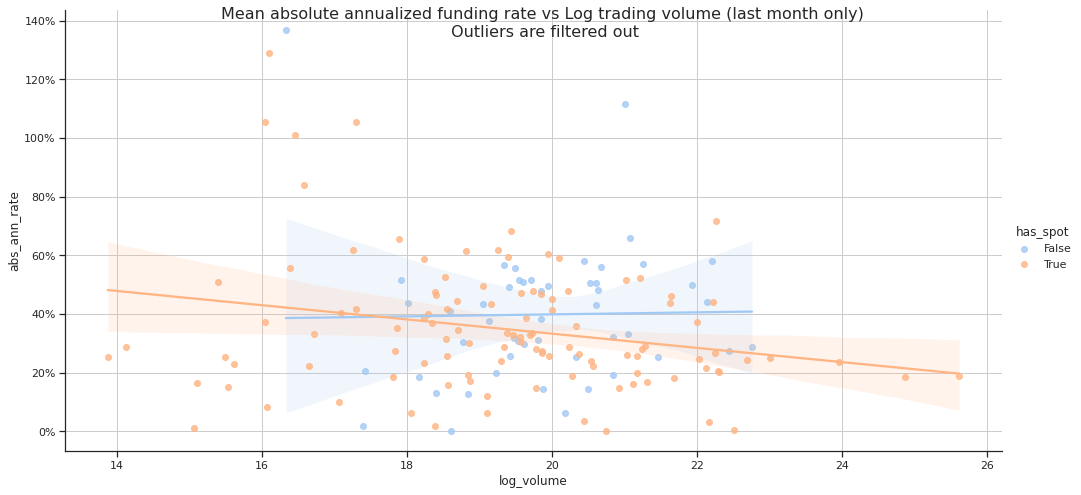

In [16]:
sns.set_style({'axes.grid' : True})
g = sns.lmplot(data = perp_df[perp_df.abs_ann_rate < 1.5], x = "log_volume", y = "abs_ann_rate", hue = "has_spot", height = 7, aspect = 2)
# g.set(xscale="log")
# ax.axhline(0, ls = '--', lw = 0.7, c = 'black')
g.axes[0][0].yaxis.set_major_formatter(mtick.PercentFormatter(1, 0))
plt.suptitle('Mean absolute annualized funding rate vs Log trading volume (last month only)\n Outliers are filtered out', fontsize = def_title_size)
plt.show()

There's small premium for illiquidity but no evident premium for ability to hedge on FTX with corresponding spot market.

Let's add collateral weight...

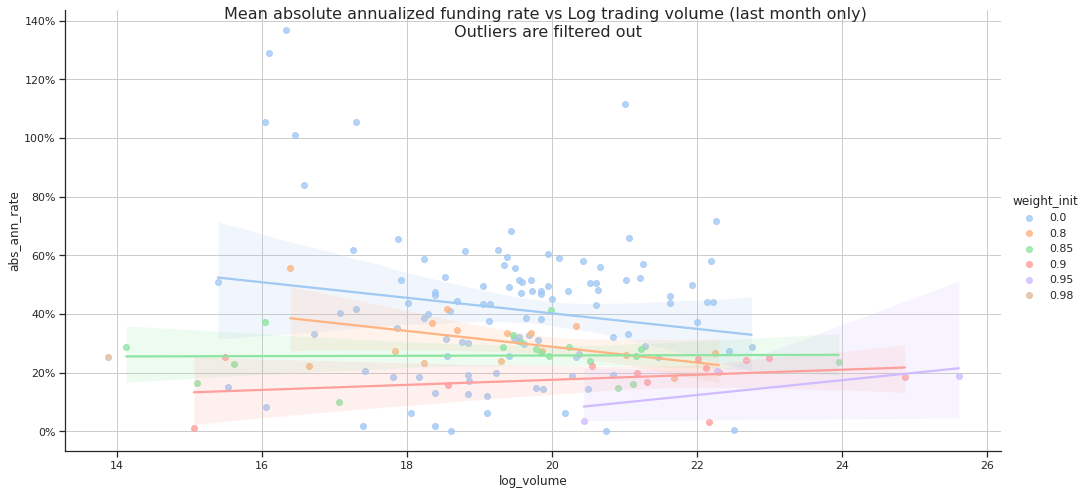

In [17]:
sns.set_style({'axes.grid' : True})
g = sns.lmplot(data = perp_df[perp_df.abs_ann_rate < 1.5], x = "log_volume", y = "abs_ann_rate", hue = "weight_init", height = 7, aspect = 2)
# g.set(xscale="log")
# ax.axhline(0, ls = '--', lw = 0.7, c = 'black')
g.axes[0][0].yaxis.set_major_formatter(mtick.PercentFormatter(1, 0))
plt.suptitle('Mean absolute annualized funding rate vs Log trading volume (last month only)\n Outliers are filtered out', fontsize = def_title_size)
plt.show()

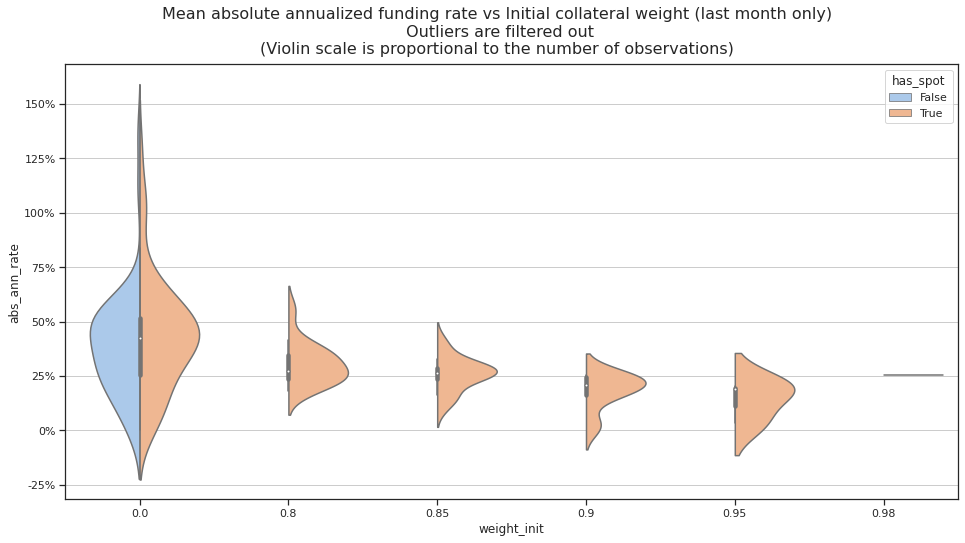

In [18]:
plt.figure(figsize = (16, 8))
sns.set_style({'axes.grid' : True})
ax = sns.violinplot(data = perp_df[perp_df.abs_ann_rate < 1.5], x = "weight_init", y = "abs_ann_rate", hue = "has_spot", split=True, scale = 'count', height = 7, aspect = 2)
# g.set(xscale="log")
# ax.axhline(0, ls = '--', lw = 0.7, c = 'black')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1, 0))
plt.suptitle('Mean absolute annualized funding rate vs Initial collateral weight (last month only)\n Outliers are filtered out\n(Violin scale is proportional to the number of observations)', fontsize = def_title_size)
plt.show()

As expected collaterizable assets provide lower returns because they can be traded with higher leverage.

Finally let's take a look at mean funding rates again, but after filtering out outliers (for last month only)

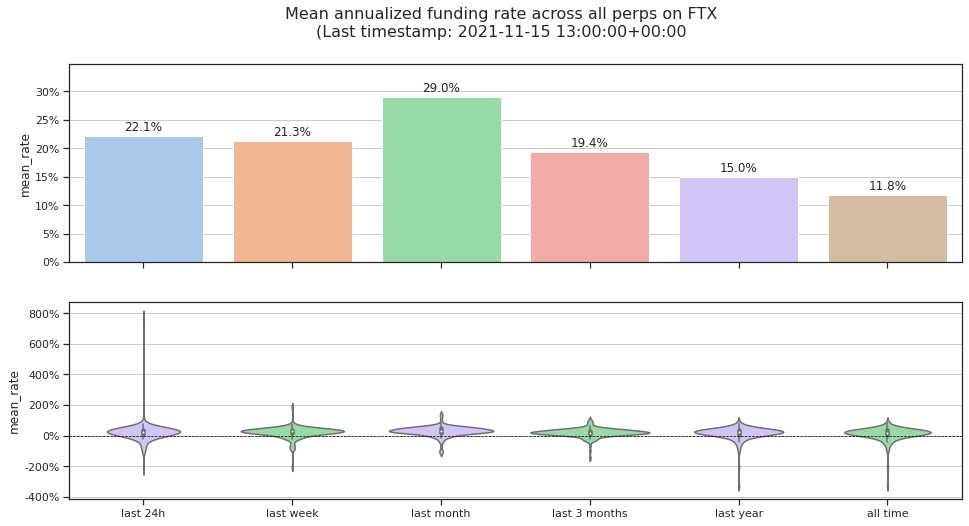

In [21]:
plot_frate(fund_rates[fund_rates.index.isin(perp_df[perp_df.abs_ann_rate < 1.5].index.values, level='symbol')])

## Managing costs

Types of costs:
* [Trading fees](https://help.ftx.com/hc/en-us/articles/360024479432-Fees) (depend on your tier and discounts)
* Spread
* "Hedging gap"

After staking 25 FTT [maker fees drop to 0](https://help.ftx.com/hc/en-us/articles/360052410392). If you stake / trade more maker fees turn negative, so you start earning on your trades.
Taker fees start from 0.07% and can be decreased by referral / FTT / volume discounts.

Every basis arb trade involves 4 transactions (each transaction can have several fills):
* Entry: buy spot / sell perp (or vice versa)
* Exit: sell spot / buy perp (or vice versa)

So if you enter/exit with aggressive market orders your **Minimum spread costs = Perp spread + Spot spread**

Actually you pay more when assets are illiquid due to market impact

"Hedging gap" arises because you cannot enter / exit your trade simultaneously. There's always some gap between spot/perp fills when you portfolio is not delta neutral. If you trade aggressively (paying taker fees) hedging gap can be minimized but cannot be eliminated. Of course you never know will you pay for not being delta neutral or will you profit.

Reasonable approach to minimize trading costs is to post limit orders on one leg and hit market order on the other leg when limit order is filled. The challenge is to manage partial fills manually on illiquid markets. So it's better to automate this step.



### Spreads

In [22]:
# Helper func
# Book - numpy array of asks or bids
# Order_amount - order size in quote currency
def calc_fill_price(book, order_amount):
  
  df = pd.DataFrame(book, columns = ['price', 'size']).astype('float')
  assert ~df.empty, 'Book is empty'
  assert (df['size'] > 0).all(), 'Book has negative entries' # Bug with SHIB-PERP
  if order_amount == 0:
    return df.iloc[0]['price']
  else:
    df['amount'] = df['price'] * df['size']
    sum_left = order_amount
    for i, row in df.iterrows():
      if sum_left == 0:
        break
      elif sum_left <= row['amount']:
        df.loc[i, 'amount_filled'] = sum_left
        sum_left = 0
        break
      else:
        df.loc[i, 'amount_filled'] = row['amount']
        sum_left -= row['amount']
    assert sum_left == 0, 'Order too big'
    df['amount_filled'] = df['amount_filled'].fillna(0)
    df['size_filled'] = df['amount_filled'] / df['price']
    return df['amount_filled'].sum() / df['size_filled'].sum()

# Calculate average ask/bid price depending on order amount
def get_avg_bid_ask_price(symbol, book_side, order_amount):

  book = ftx.fetchL2OrderBook(symbol, params = {'depth':50})
  assert book_side in ['asks', 'bids']
  return calc_fill_price(book[book_side], order_amount)

# Calculate average spread depending on order amount
def get_avg_spread(symbol, order_amount = 0):

  book = ftx.fetchL2OrderBook(symbol, params = {'depth':50})
  if isinstance(order_amount, Iterable):
    spreads = []
    for order in order_amount:
      bid_price = calc_fill_price(book['bids'], order)
      ask_price = calc_fill_price(book['asks'], order)
      spreads.append((ask_price - bid_price) / ((ask_price + bid_price) / 2))
    return spreads
  else:
    bid_price = calc_fill_price(book['bids'], order_amount)
    ask_price = calc_fill_price(book['asks'], order_amount)
    return (ask_price - bid_price) / ((ask_price + bid_price) / 2)

# get_avg_bid_ask_price('BTC-PERP', 'asks', 10000)
# get_avg_bid_ask_price('BTC-PERP', 'bids', 100000)
# get_avg_spread('BTC-PERP', [0, 1000, 10000, 100000])
# get_avg_spread('SHIB-PERP', 100000)

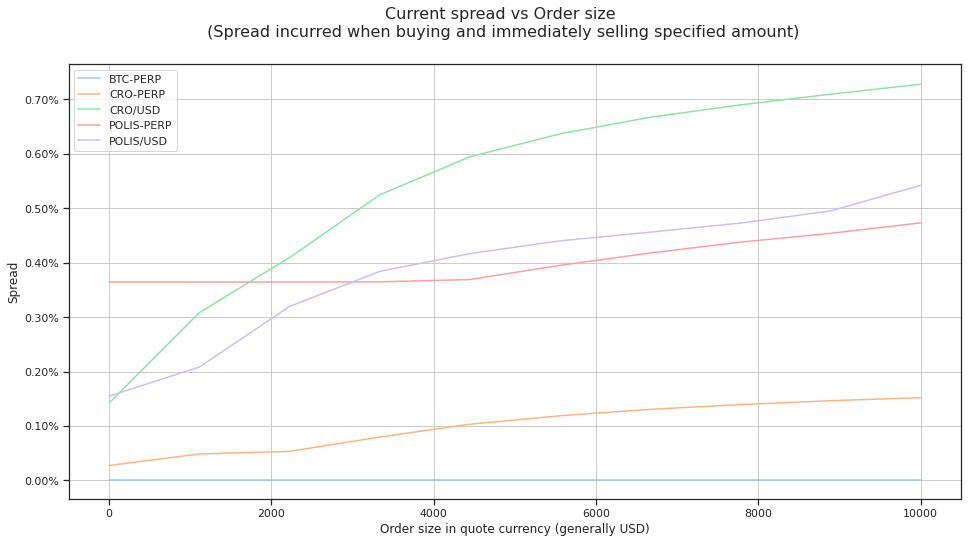

In [23]:
sym_list = ['BTC-PERP', 'CRO-PERP', 'CRO/USD', 'POLIS-PERP', 'POLIS/USD']
order_amounts = np.linspace(0, 10000, 10)
spreads_df = pd.DataFrame(index = order_amounts)
for sym in sym_list:
  spreads_df[sym] = get_avg_spread(sym, order_amounts)

ax = spreads_df.plot(figsize = (16, 8), grid = True)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1, 2))
ax.set_xlabel('Order size in quote currency (generally USD)')
ax.set_ylabel('Spread')
plt.suptitle('Current spread vs Order size\n (Spread incurred when buying and immediately selling specified amount)', fontsize = def_title_size)
plt.show()

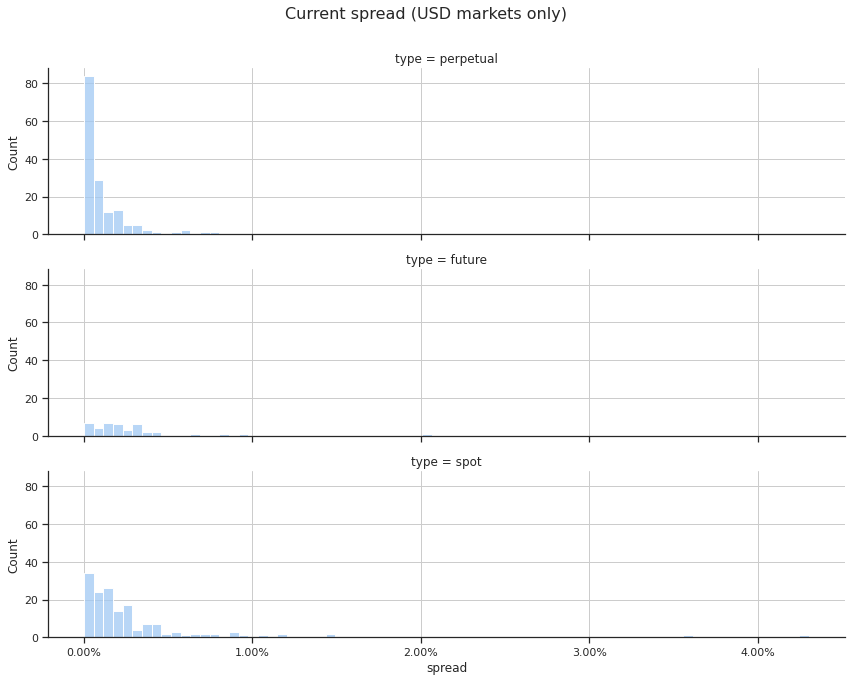

In [24]:
spread_df = pd.DataFrame([data['info'] for m, data in ftx.load_markets(reload = True).items()])[['name', 'bid', 'ask', 'price', 'underlying', 'volumeUsd24h']]
spread_df = spread_df.set_index('name').astype({'bid':'float', 'ask':'float', 'price':'float', 'volumeUsd24h':'float'})
spread_df['spread'] = (spread_df['ask'] - spread_df['bid']) / ((spread_df['ask'] + spread_df['bid'])/2)
spread_df = spread_df.join(markets, how = 'inner').rename_axis('symbol', axis = 0)
spread_df = spread_df[~spread_df.is_index] # Remove indices
spread_df = spread_df[spread_df.quote == 'USD'] # Only USD quoted markets
spread_df = spread_df[spread_df.volumeUsd24h > 0] # Trading volume > 0
spread_df['log_volume'] = np.log(spread_df['volumeUsd24h'])
spread_df = spread_df[spread_df.bid <= spread_df.ask] # Remove erroneous orderbooks (e.g. SHIB-PERP)
# spread_df['spread'].sort_values()
# ax = sns.histplot(data = spread_df, x="spread", hue = 'type')
sns.set_style({'axes.grid' : True})
g = sns.displot(data = spread_df, x = "spread", row = 'type', height = 3, aspect = 4)
g.axes[0][0].xaxis.set_major_formatter(mtick.PercentFormatter(1, 2))
plt.suptitle('Current spread (USD markets only)', y = 1.05, fontsize = def_title_size)
plt.show()

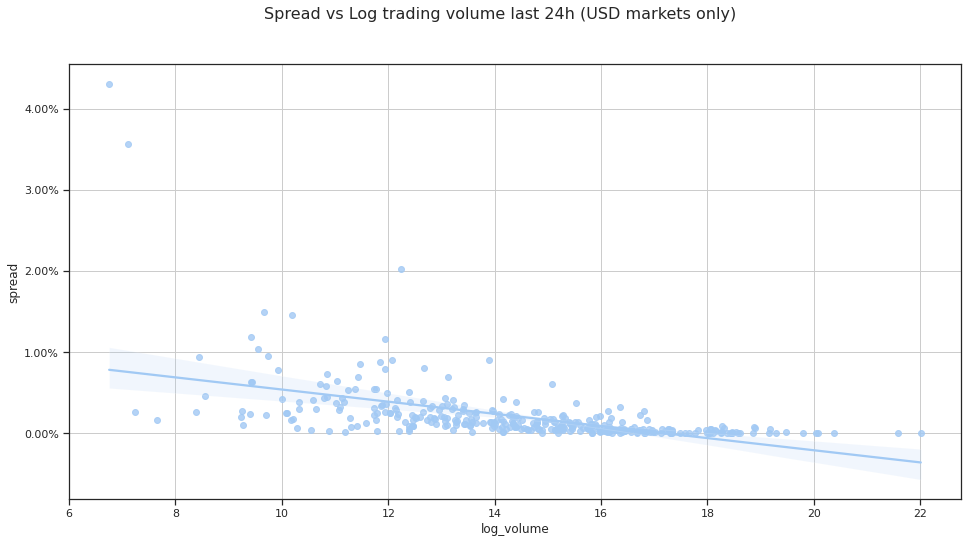

In [25]:
plt.figure(figsize = (16, 8))
sns.set_style({'axes.grid' : True})
ax = sns.regplot(data = spread_df, x = "log_volume", y = "spread")
# ax.axhline(0, ls = '--', lw = 0.7, c = 'black')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1, 2))
plt.suptitle('Spread vs Log trading volume last 24h (USD markets only)', fontsize = def_title_size)
plt.show()

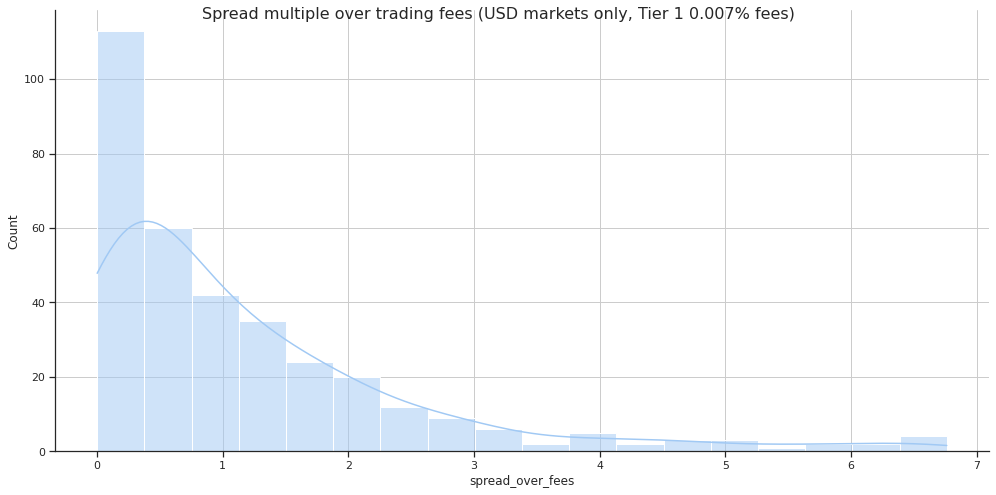

In [26]:
spread_df['spread_over_fees'] = spread_df['spread'] / (0.0007 * 2)
sns.set_style({'axes.grid' : True})
ax = sns.displot(data = spread_df[spread_df.spread < 0.01], x = "spread_over_fees", kde = True, height = 7, aspect = 2)
plt.suptitle('Spread multiple over trading fees (USD markets only, Tier 1 0.007% fees)', fontsize = def_title_size)
plt.show()

In [27]:
# Spreads of some popular assets
spread_df.loc[['BTC-PERP', 'DOGE-PERP', 'CRO-PERP', 'LINA-PERP'], ['spread', 'volumeUsd24h']].style.format('{:.4%}', subset = ['spread']).format('{:0,.0f}', subset = ['volumeUsd24h'])

,spread,volumeUsd24h
symbol,,
BTC-PERP,0.0015%,"3,624,177,389"
DOGE-PERP,0.0002%,"103,287,249"
CRO-PERP,0.0766%,"158,087,255"
LINA-PERP,0.1086%,"7,492,458"


For some assets you should care about the spread and disregard trading fees

### How long does it take to recoup your costs?

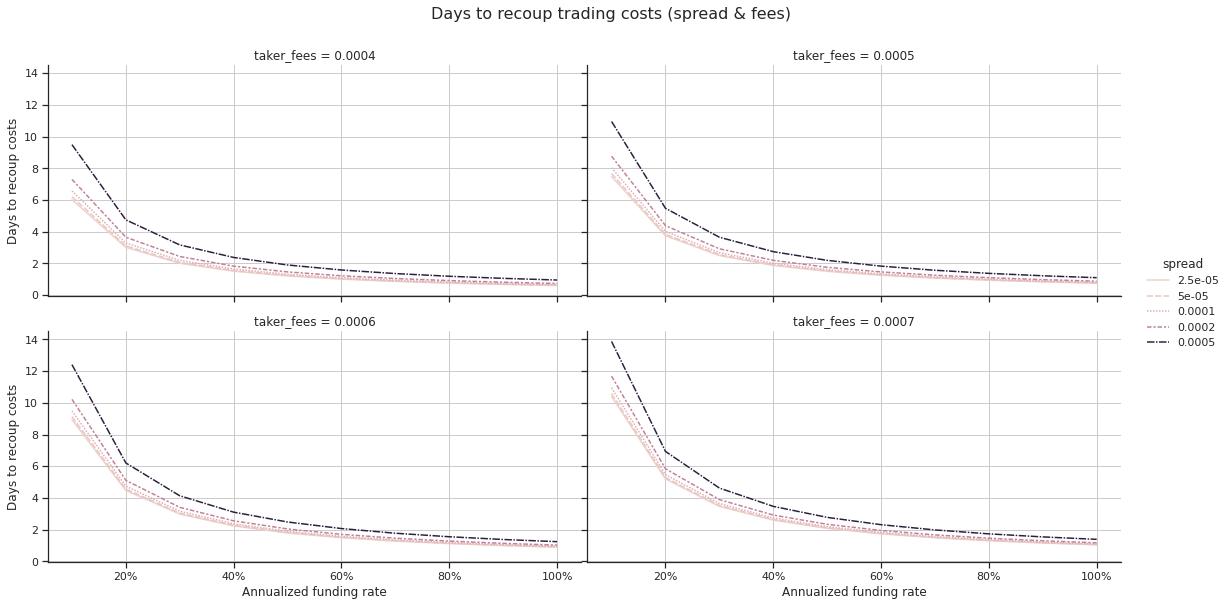

In [28]:
mean_frates = np.linspace(0.1, 1, 10)
taker_fees = [0.0004, 0.0005, 0.0006, 0.0007]
spread = [0.000025, 0.000050, 0.0001, 0.0002, 0.0005]
costs_df = pd.DataFrame(index = pd.MultiIndex.from_product([mean_frates, taker_fees, spread])).rename_axis(['ann_rate', 'taker_fees', 'spread'], axis = 0).reset_index()
costs_df['recoup_days'] = (costs_df['taker_fees'] * 4 + costs_df['spread'] * 2) / (costs_df['ann_rate'] / 365)

sns.set_style({'axes.grid' : True})
g = sns.relplot(
    data=costs_df,
    x="ann_rate", y="recoup_days",
    hue="spread", style="spread", col="taker_fees", col_wrap = 2,
    height=4, aspect=2, kind="line"
)
g.axes[0].xaxis.set_major_formatter(mtick.PercentFormatter(1, 0))
g.set_axis_labels("Annualized funding rate", "Days to recoup costs")
g.tight_layout(w_pad=0)
plt.suptitle('Days to recoup trading costs (spread & fees)', y = 1.05, fontsize = def_title_size)
plt.show()

So it takes about 1 week to breakeven with 20% mean annualized funding rate, tier 1 taker fees and aggressive market orders on entry and exit. In case spread does not change

## How big can you trade?

It depends on:
* Maximum leverage of your account
* Collateral weight of spot coin
* Type of trade (long spot / short perp or vice versa)

Let's consider standard long spot / short perp trade...

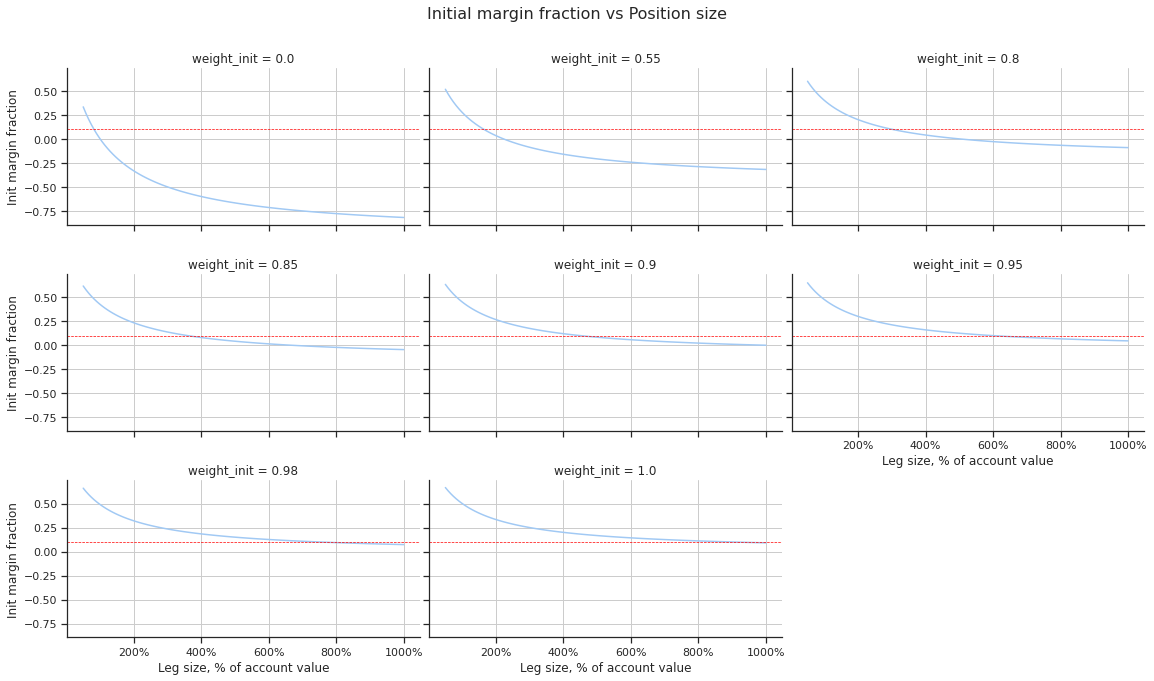

In [29]:
init_weights = np.sort(currs['weight_init'].unique())
total_weights = np.sort(currs['weight_total'].unique())
pos_pct = np.linspace(0.5, 10, 120)
init_amount = 1000
max_leverage = 10

margin_df = pd.DataFrame(index = pd.MultiIndex.from_product([init_weights, pos_pct])).rename_axis(['weight_init', 'pos_pct'], axis = 0).reset_index()
margin_df['coin_notional'] = margin_df['pos_pct'] * init_amount
margin_df['perp_notional'] = margin_df['pos_pct'] * init_amount
margin_df['usd_notional'] = init_amount - margin_df['coin_notional']
margin_df['total_notional'] = margin_df['usd_notional'] + margin_df['coin_notional'] + margin_df['perp_notional']
margin_df['coin_coll'] = margin_df['coin_notional'] * margin_df['weight_init']
margin_df['usd_coll'] = margin_df['usd_notional']
margin_df['perp_coll'] =  -1 * margin_df['perp_notional'] * 0.1
margin_df['total_coll'] = margin_df['coin_coll'] + margin_df['usd_coll'] + margin_df['perp_coll']
margin_df['available_coll'] = margin_df['total_coll'].apply(lambda x: max(x, 0))
margin_df['acc_value_total'] = margin_df['coin_coll'] + margin_df['usd_coll']
margin_df['acc_value_net'] = margin_df['usd_notional'] + margin_df['coin_notional']
margin_df['mf'] = margin_df['acc_value_total'] / margin_df['total_notional']
margin_df['leverage'] = 1 / margin_df['mf']
margin_df['base_imf'] = 1 / max_leverage
# margin_df[margin_df.weight_init == 0.9]

sns.set_style({'axes.grid' : True})
g = sns.relplot(
    data=margin_df,
    x="pos_pct", y="mf",
    col="weight_init", col_wrap = 3,
    height=3, aspect=1.8, kind="line"
)
g.axes[0].xaxis.set_major_formatter(mtick.PercentFormatter(1, 0))
# g.map(plt.axhline, y=0, color=".7", dashes=(2, 1), zorder=0)
g.map(plt.axhline, y= 1 / max_leverage, ls = '--', lw = 0.7, c = 'red')
g.set_axis_labels("Leg size, % of account value", "Init margin fraction")
g.tight_layout(w_pad=0)
plt.suptitle('Initial margin fraction vs Position size', y = 1.05, fontsize = def_title_size)
plt.show()

It's easy to show that

$p_{max} = \frac{L_{max}-1}{1-(w_{init}-1)*L_{max}}$ ,

where
  
> $p_{max}$ - Max initial position size 
  
> $L_{max}$ - Max account leverage (default = 10)

> $w_{init}$ - Initial collateral weight


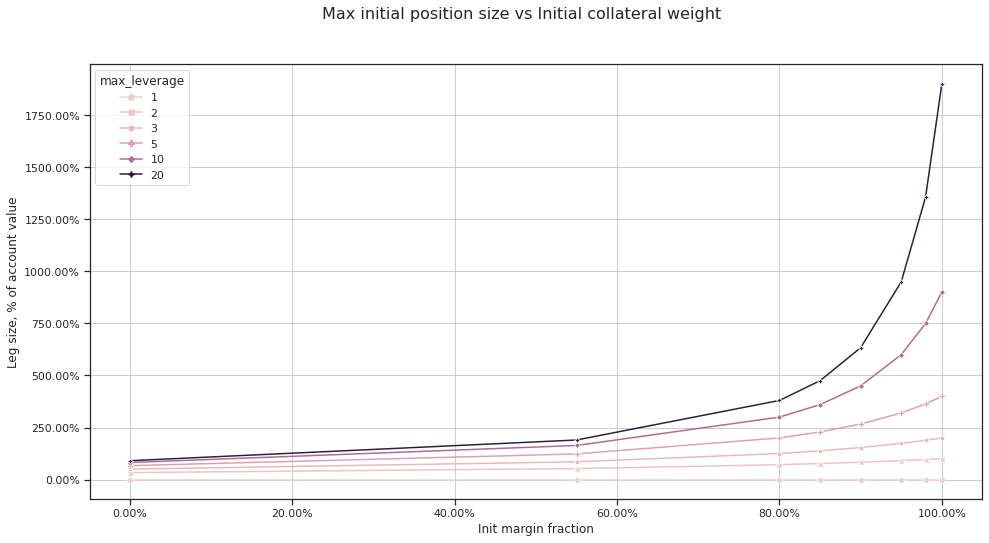

In [30]:
init_weights = np.sort(currs['weight_init'].unique())
total_weights = np.sort(currs['weight_total'].unique())
max_leverage = [1, 2, 3, 5, 10, 20]
max_pos = pd.DataFrame(index = pd.MultiIndex.from_product([init_weights, max_leverage])).rename_axis(['weight_init', 'max_leverage'], axis = 0).reset_index()
max_pos['max_pos'] = (max_pos['max_leverage'] - 1) / (1 - (max_pos['weight_init'] - 1) * max_pos['max_leverage'])

plt.figure(figsize = (16, 8))
ax = sns.lineplot(data = max_pos, x = 'weight_init', y = 'max_pos', hue = 'max_leverage', style = 'max_leverage', markers=True, dashes=False)
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1, 2))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1, 2))
ax.set_xlabel('Init margin fraction')
ax.set_ylabel('Leg size, % of account value')
plt.suptitle('Max initial position size vs Initial collateral weight', fontsize = def_title_size)
plt.show()

In [31]:
max_pos[max_pos.max_leverage == 10].set_index('weight_init').style.format('{:.2%}', subset = ['max_pos'])

,max_leverage,max_pos
weight_init,,
0.0,10,81.82%
0.55,10,163.64%
0.8,10,300.00%
0.85,10,360.00%
0.9,10,450.00%
0.95,10,600.00%
0.98,10,750.00%
1.0,10,900.00%


**So with BTC pair you can size more than 7x, but with shitcoins only ~0.8x**

Of course you have to take into account:
* Maintenance margin
* Influence of price movements on your margin
* Unrealized & realized PnL of futures positions
* Funding payments
* Borrowing and lending
* Other constraints of FTX exchange (IMF factors, etc.)



## Shitcoins are more profitable than top-10 coins?

When trading on margin you incur borrowing costs with flexible lending rates.

When you have spare money you can lend your funds and increase your returns.

Let's extend previous simulation and calculate expected returns depending on initial collateral weight and mean funding, borrowing and lending rates.

**This is not a full-fledged backtest because we don't take into account very important factors like price changes, etc!!!**

**Also this test assumes that we trade on maximum margin and lend all available assets. Obviously it's not possible in real life.**

**So you can consider these results as maximum theoretical ex-post returns for "buy-and-hold" portfolio without asset price volatility.**




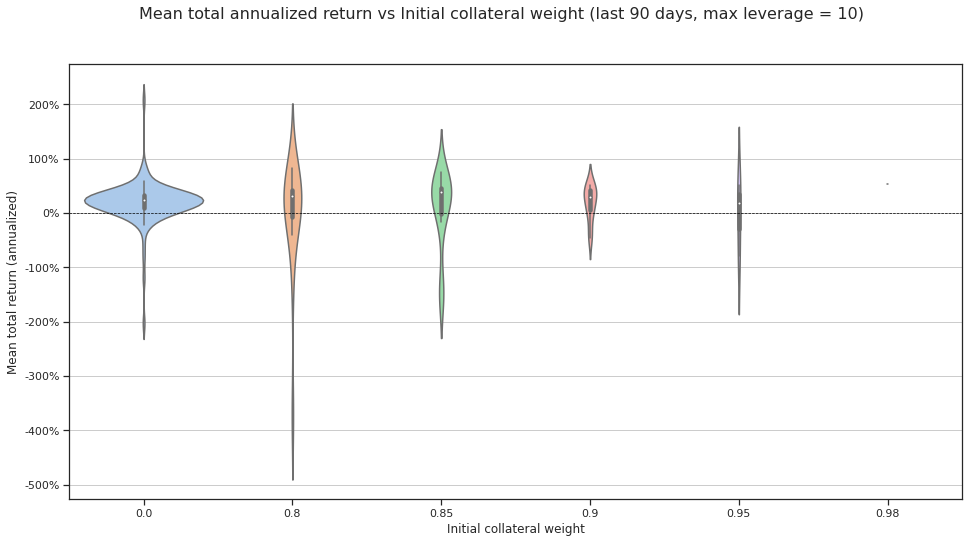

In [32]:
# days - # of days to "backtest"
def bt_perp_arb_rough(symbols = None, days = 30, max_leverage = 10, plot = 'violin', show_labels = False):

  if symbols is not None:
    fr = fund_rates.loc(axis = 0)[(fund_rates.index.get_level_values('ts').max() - pd.DateOffset(days = days)):, symbols].groupby('symbol')['ann_rate'].mean().to_frame()
  else:
    fr = fund_rates.loc(axis = 0)[(fund_rates.index.get_level_values('ts').max() - pd.DateOffset(days = days)):, ].groupby('symbol')['ann_rate'].mean().to_frame()
  fr.rename(columns = {'ann_rate':'fund_rate'}, inplace = True)
  perp_spot_mapping = markets[markets.perpetual]['base'].rename_axis('perp', axis = 0).reset_index().merge(markets[~markets.future & (markets.quote == 'USD')]['base'].reset_index(), how = 'left', on = 'base')
  perp_spot_mapping['has_spot'] = perp_spot_mapping['symbol'].notnull()
  perp_df = fr.join(markets[['base', 'is_index']]).reset_index()
  perp_df = perp_df.merge(perp_spot_mapping[['perp', 'has_spot']].set_index('perp'), how = 'left', left_on='symbol', right_on='perp').set_index('symbol')
  perp_df = perp_df.reset_index().merge(currs['weight_init'], how = 'left', left_on='base', right_on='curr_code').set_index('symbol')
  perp_df['lend_rate'] = lend_hist.loc(axis = 0)[(lend_hist.index.get_level_values('ts').max() - pd.DateOffset(days = days)):, 'USD']['ann_rate'].mean()
  perp_df['max_leverage'] = max_leverage
  perp_df['max_pos'] = (perp_df['max_leverage'] - 1) / (1 - (perp_df['weight_init'] - 1) * perp_df['max_leverage'])
  perp_df['fund_return'] = (perp_df['fund_rate'] * days / 365) * perp_df['max_pos']
  perp_df['borr_costs'] = (perp_df['lend_rate'] * 1.3 * days / 365) * (1 - perp_df['max_pos']).apply(lambda x: min(x, 0))
  perp_df['lend_proceeds'] = (perp_df['lend_rate'] * days / 365) * (1 - perp_df['max_pos']).apply(lambda x: max(x, 0))
  perp_df['total_period_return'] = perp_df['fund_return'] + perp_df['borr_costs'] + perp_df['lend_proceeds']
  perp_df['total_ann_return'] = perp_df['total_period_return'] * 365 / days
  # return perp_df
  
  plt.figure(figsize = (16, 8))
  if plot == 'violin':
    ax = sns.violinplot(data = perp_df, x = "weight_init", y = "total_ann_return", scale = 'count', height = 7, aspect = 2)
    ax.set_xlabel('Initial collateral weight')
    plt.suptitle(f'Mean total annualized return vs Initial collateral weight (last {days} days, max leverage = {max_leverage})', fontsize = def_title_size)
  elif plot == 'scatter':
    ax = sns.scatterplot(data = perp_df, x = "fund_rate", y = "total_ann_return", hue = "weight_init", style = "weight_init")
    ax.set_xlabel('Mean funding rate (annualized)')
    ax.xaxis.set_major_formatter(mtick.PercentFormatter(1, 0))  
    plt.suptitle(f'Mean total annualized return vs Funding rate (last {days} days, max leverage = {max_leverage})', fontsize = def_title_size)
    if show_labels:
      for line in range(0, perp_df.shape[0]):
        ax.text(perp_df.fund_rate[line] + 0.003, perp_df.total_ann_return[line] - 0.003, 
                perp_df.index[line], horizontalalignment='left', 
                size='medium', color='black', weight='regular')

  ax.axhline(0, ls = '--', lw = 0.7, c = 'black')
  ax.set_ylabel('Mean total return (annualized)')
  ax.yaxis.set_major_formatter(mtick.PercentFormatter(1, 0))
  plt.show()

bt_perp_arb_rough(symbols = None, days = 90, max_leverage = 10, plot = 'violin', show_labels = False)

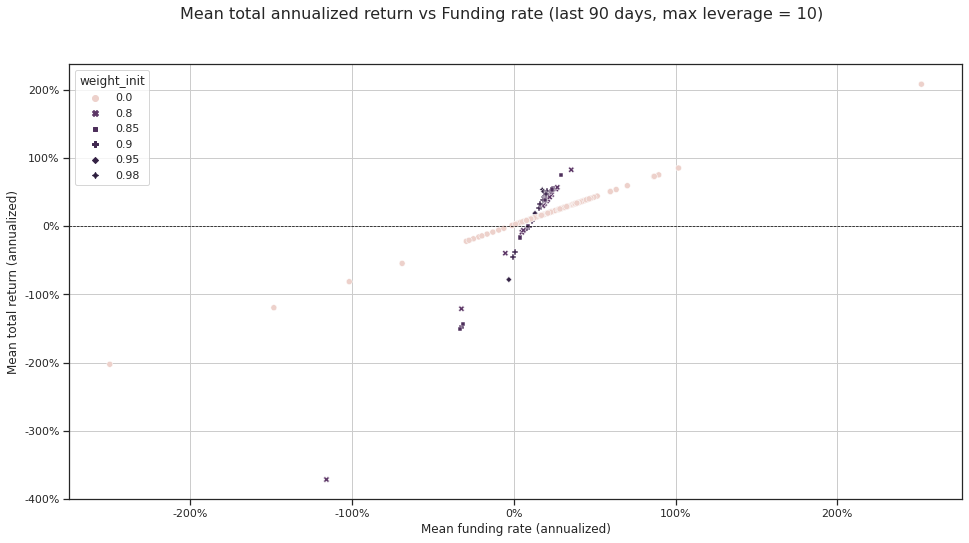

In [33]:
bt_perp_arb_rough(symbols = None, days = 90, max_leverage = 10, plot = 'scatter', show_labels = False)

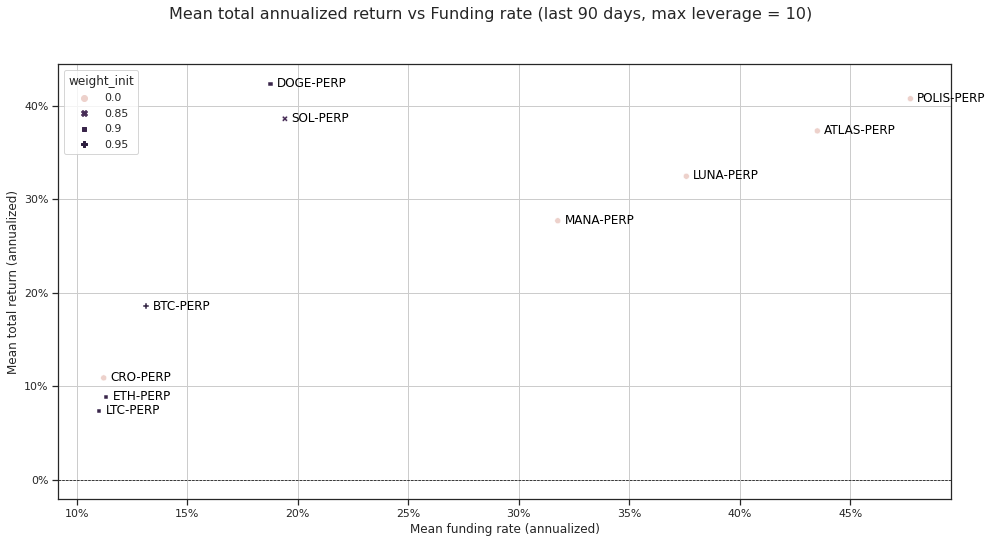

In [34]:
bt_perp_arb_rough(symbols = ['BTC-PERP', 'ETH-PERP', 'DOGE-PERP', 'SOL-PERP', 'LTC-PERP', 'MANA-PERP', 'CRO-PERP', 'ATLAS-PERP', 'POLIS-PERP', 'LUNA-PERP'], days = 90, max_leverage = 10, plot = 'scatter', show_labels = True)

It seems that trading shitcoins is not always rewarded with higher profits if we consider "buy-and-hold" scenario with maximum allowed leverage. 

## If 30-40% return is not enough

Funding payments are good sources of returns but what about execution alpha? Can you sell high and buy low?

Ideally when doing standard perp arb with long spot / short perp you should enter the trade when basis is high and exit when basis is low. And immediately after basis flip long perp / short spot until basis converges.


In [35]:
def plot_premia_frate(curr, tf = '1d', since = None, till = None, bar_type = 'close', plot_index = False):

  assert since is not None, 'Since param id required'

  pdf = get_ohlcv(curr + '-PERP', timeframe = tf, since = since, till = till, index = False)[ftx.iso8601(since):]
  if plot_index:
    idf = get_ohlcv(curr + '-PERP', timeframe = tf, since = since, till = till, index = True)[ftx.iso8601(since):]
  if (curr + '/USD') in ftx.markets:
    sdf = get_ohlcv(curr + '/USD', timeframe = tf, since = since, till = till, index = False)[ftx.iso8601(since):]

  fig, axs = plt.subplots(3, figsize=(16,8), sharex = True, gridspec_kw={'height_ratios': [1, 1, 1]})
  pdf[bar_type].plot(ax = axs[0], lw = 0.7, label = f'{curr}-PERP')
  if plot_index:
    idf[bar_type].plot(ax = axs[0], lw = 0.7, label = f'{curr} index')
  if (curr + '/USD') in ftx.markets:
    sdf[bar_type].plot(ax = axs[0], lw = 0.7, label = f'{curr}/USD')
  axs[0].set_title(f'{curr} {bar_type} price')
  axs[0].grid(True)
  axs[0].legend()

  if (curr + '/USD') in ftx.markets:
    perp_spot_premia = (pdf[bar_type] - sdf[bar_type]) / sdf[bar_type]
    perp_spot_premia.plot(ax = axs[1], lw = 0.7, label = 'PERP/SPOT premium')
  if plot_index:
    perp_index_premia = (pdf[bar_type] - idf[bar_type]) / idf[bar_type]
    perp_index_premia.plot(ax = axs[1], lw = 0.7, label = 'PERP/INDEX premium')
  axs[1].set_title('Premia')
  axs[1].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
  axs[1].grid(True)
  axs[1].axhline(0, ls = '--', lw = 0.7, c = 'black')
  axs[1].legend()

  if till is not None:
    ts_fhist = fund_rates.loc(axis = 0)[ftx.iso8601(since):ftx.iso8601(till), curr + '-PERP']
  else:
    ts_fhist = fund_rates.loc(axis = 0)[ftx.iso8601(since):, curr + '-PERP']
  ts_fhist = ts_fhist['ann_rate'].unstack().sort_index()[ftx.iso8601(since):].reindex(pdf.index, method = 'ffill')

  ts_fhist.plot(ax = axs[2], lw = 0.7, label = ts_fhist.columns.values[0])
  axs[2].grid(True)
  axs[2].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
  axs[2].set_xlabel('')
  axs[2].axhline(0, ls = '--', c = 'black')
  axs[2].axhline(ts_fhist.mean().squeeze(), ls = '-', lw = 0.7, c = 'red')
  axs[2].legend()
  axs[2].set_title('Hourly funding rates (annualized)')

  plt.show()

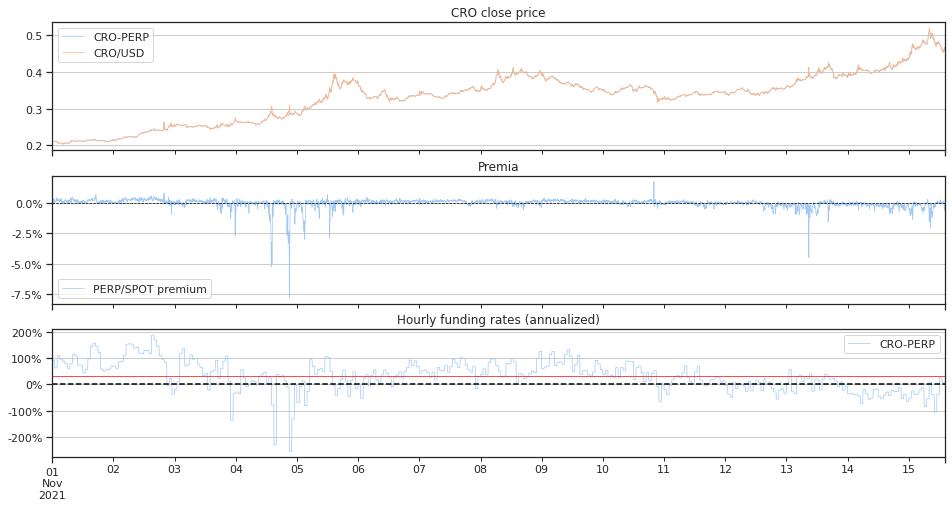

In [36]:
plot_premia_frate('CRO', tf = '5m', since = ftx.parse8601('2021-11-01T00:00:00Z'), till = None, bar_type = 'close', plot_index = False)

In November 2021 CRO perps traded several times at huge discount to spot!! Discount ranged from -3 to -7%. Figure above shows 5m candles (close price). It means that basis was negative for at least several minutes/seconds.

Let's zoom in to 1m candles...

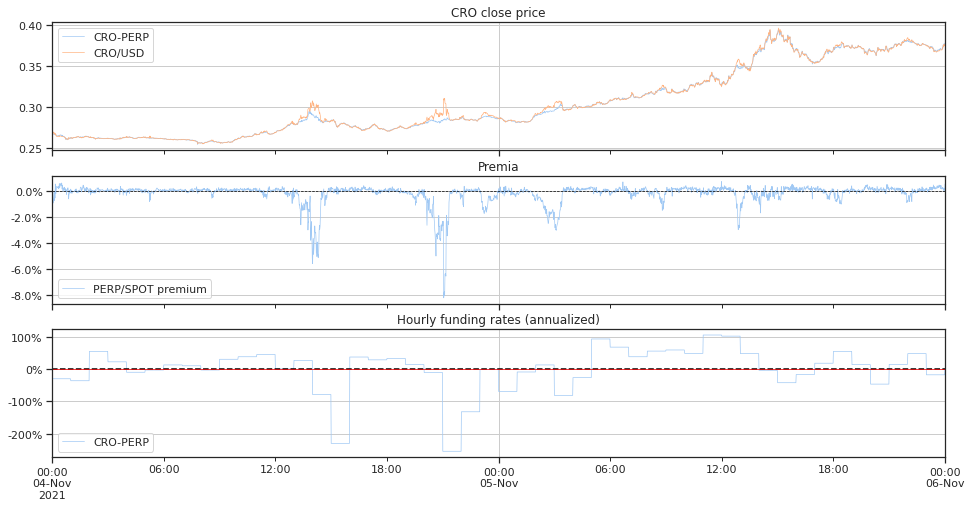

In [37]:
plot_premia_frate('CRO', tf = '1m', since = ftx.parse8601('2021-11-04T00:00:00Z'), till = ftx.parse8601('2021-11-06T00:00:00Z'), bar_type = 'close', plot_index = False)

3-5% instant profit opportunity was open for several minutes!
Can you set take profit order? Sure!!

Go to [FTX Quantzone](https://ftx.com/quant-zone/rules) and set automatic rules to capture negative basis.

## Other opportunities

* Long perp / short spot
* Perp / expiring futures arb
* Cross exchange basis arb
* ...

## Some caveats

1. There're some weird [constraints](https://help.ftx.com/hc/en-us/articles/360031149632-Non-USD-Collateral) on FTX:

>> *FTX will trade your non-USD collateral into USD if your USD balance is negative and any of the following hold:*
- *You are close to liquidation: your account's margin fraction is less than 
(20bps + maintenance margin fraction requirement)*
- *Your negative USD balance is large: over $30,000 in magnitude*
- *Your negative USD balance is large when compared to overall collateral: its magnitude is over 4 times larger than your net account collateral*

>> Probably it applies only to non-margin accounts:

  >> *Instead of having your collateral converted into USD, you can choose to be charged interest on your negative USD balance past -$30,000 at market rates determined by the funding market. Negative balances will require margin in the same way that futures positions do, and the default threshold for collateral conversions will be the same as for futures liquidations, i.e. being below maintenance margin.*

2. Beware of huge funding rates. There's always some reason behind it that you're not aware of (see OMG coin case)
3. Some coins have caveats, e.g. AMPL


## Next steps



1. Predicting future funding rates and market timing
2. Full-fledged backtests
3. Rebalancing
4. Trade automation

